# Modelado de los Datos
A lo largo de este notebook se cubre la cuarta fase de la metodología CRIPS-DM, en este caso el modelado del conjunto de datos. En este notebook se incluye el modelado mediante el modelo 

1. **Comprensión del Negocio (Business Understanding)**
   - Consistente en el entendimiento del objetivo del proyecto.

2. **Comprensión de los Datos (Data Understanding)**
   - Relacionada con la carga y primera evaluación del conjunto de datos. Se divide a su vez en :


3. **Preparación de los Datos (Data Preparation)** 
   - Consistente en la limpieza, preparación y extracción de características de los datos.

4. <span style="color:#66FF99;">**Modelado (Modeling)**</span>
   - Relacionada con la elección del modelo de machine learning y el ajuste hiperparamétrico. En este caso se incluye el modelo más basico que se tomará como baseline, en este caso UNET

5. **Evaluación (Evaluation)**  
   - Evaluación de los resultados obtenidos por el modelo.

6. **Implementación (Deployment)**  
   - Integración del modelo de forma que sea accesible para su uso.



Con los datos seleccionados del conjunto de datos, pasamos a generar nuevos datos adicionales que nos permitan entrenar el modelo con una cuantia de datos aun mayor dadas las clases seleccionadas, además de extraer nuevas características de nuestras imágemes para obtener mejores resultados con los modelos a usar. Es por ello que este apartado se divide en dos etapas:

1. Muestreado y ajuste de las imágenes

2. Generación de imágenes derivadas de las actuales

3. Uso de modelos fundacionales

### 1. Sampleado del conjunto de datos

Este primer apartado abarca la corrección de aquellas deficiencias enconrtadas a lo largo del notebook anterior, relativo al análisis exploratorio de los datos.

A lo largo de esta primera parte del noteobook se procederá a la realización del sampleo de instancias del dataset inicial, dando como salida en este caso un dataset nativo de tensorflow `tf.dataset`, que permitirá que el entrenamierto del modelo sea lo más rápido posible. Los objetivos de este apartado serán varios:

- La eliminación las máscaras demasiado pequeñas, para facilitar el aprendijaze del modelo

- La obtención de  un conjunto de entrenamieto mucho más balanceado

In [ ]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
import matplotlib.patches as mpatches
from tensorflow.keras import layers, models
from utils import  load_yaml_file

from tqdm import tqdm
from pycocotools.coco import COCO


from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns



Se carga toda la info necesaria del conjunto de datos:

In [ ]:
yaml = load_yaml_file()

objetives = yaml["objetive_classes"]
N =10000# yaml["size_sample"]


N_CLASSES = len(objetives) + 1

DIR_TRAIN_ANNOTATIONS = yaml["dirs"]["anotaciones"]["train"]
DIR_TRAIN_IMGS = yaml["dirs"]["imagenes"]["train"]
DIR_TRAIN_IMGS = os.path.abspath(os.path.join(os.getcwd(), "..", DIR_TRAIN_IMGS))

coco=COCO(os.path.join(os.getcwd(),"..", DIR_TRAIN_ANNOTATIONS))

loading annotations into memory...
Done (t=24.92s)
creating index...
index created!


En este caso dado que el entrenamiento se ha realizado en google drive se realiza la carga de los ficheros del mismo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tfrecord_path_train = r"/content/drive/MyDrive/TFM/dataset_train.tfrecord"
tfrecord_path_test = r"/content/drive/MyDrive/TFM/dataset_test.tfrecord"

batch_size = 16



In [ ]:
def parse_tfrecord(example_proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        #"mask": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "mask_shape": tf.io.FixedLenFeature([2], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)

    img = tf.io.decode_jpeg(example["image"]) 
    img = tf.image.convert_image_dtype(img, tf.float32)  
 
    #mask = tf.io.decode_png(example["mask"], channels=0) 

    # mask = tf.io.decode_raw(example["mask"], tf.uint8)
    # mask = tf.reshape(mask, example["mask_shape"])
    shape = example["mask_shape"]
    mask = tf.io.decode_raw(example["mask"], tf.uint8)
    mask = tf.reshape(mask, shape)
    mask = tf.one_hot(mask, depth=N_CLASSES)
    
    return img, mask





In [ ]:
def load_dataset(tfrecord_path, batch_size=32, shuffle_buffer=100, training=True):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

    dataset = raw_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        dataset = dataset.shuffle(shuffle_buffer)
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset



# Load dataset
train_ds = load_dataset(tfrecord_path_train, batch_size=4)

# Example: loop through a batch
for img_batch, mask_batch in train_ds.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

In [ ]:
def augment_data(image, mask):
    if tf.random.uniform(()) > 0.85:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # if tf.random.uniform(()) > 0.5:
    #     image = tf.image.flip_up_down(image)
    #     mask = tf.image.flip_up_down(mask)

    if tf.random.uniform(()) > 0.95:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
        mask = tf.image.rot90(mask, k)
    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_brightness(image, delta=tf.random.uniform([], -0.1, 0.1))

    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_contrast(image, contrast_factor=tf.random.uniform([], 0.9, 1.1))

    if tf.random.uniform(()) > 0.85:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.2, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # # Random zoom (cropping and resizing)
    # if tf.random.uniform(()) > 0.95:
    #     scale = tf.random.uniform([], 0.8, 1.2)
    #     original_size = tf.shape(image)[:2] 
    #     new_size = tf.cast(tf.cast(original_size, tf.float32) * scale, tf.int32) 
    #     image = tf.image.resize(image, new_size)
    #     mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #     image = tf.image.resize_with_crop_or_pad(image, tf.shape(image)[0], tf.shape(image)[1])
    #     mask = tf.image.resize_with_crop_or_pad(mask, tf.shape(mask)[0], tf.shape(mask)[1])

    return image, mask

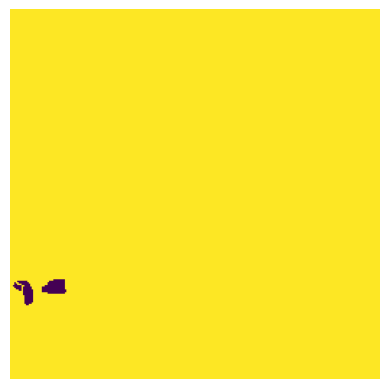

In [ ]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    return image, mask

In [ ]:

dataset_test = tf.data.TFRecordDataset(tfrecord_path_test)
dataset_test = dataset_test.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

dataset_test = dataset_test.padded_batch(
    batch_size=16,
    padding_values=(tf.constant(0.0, dtype=tf.float32),  # Image padding (float32)
                    tf.constant(0, dtype=tf.uint8)),     # Mask padding (uint8)
    padded_shapes=([None, None, 3], [None, None, N_CLASSES])
)

dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)

# Use in training
for batch in dataset_test.take(1):
    print(batch[0].shape, batch[1].shape)

(16, 256, 256, 3) (16, 256, 256, 4)


In [ ]:
train_dataset = load_dataset(tfrecord_path_train, batch_size=4, training=True)
# Example: loop through a batch
for img_batch, mask_batch in train_ds.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

In [15]:

# Select a random image
img_ids = coco.getImgIds()
img_id = random.choice(img_ids)
img_info = coco.loadImgs(img_id)[0]

# Load image
img_path = os.path.join(DIR_TRAIN_IMGS, img_info['file_name'])
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

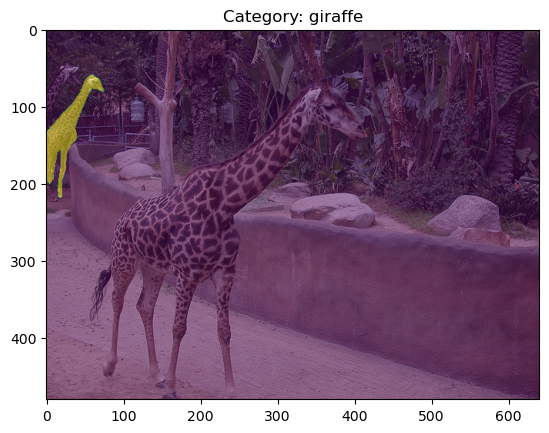

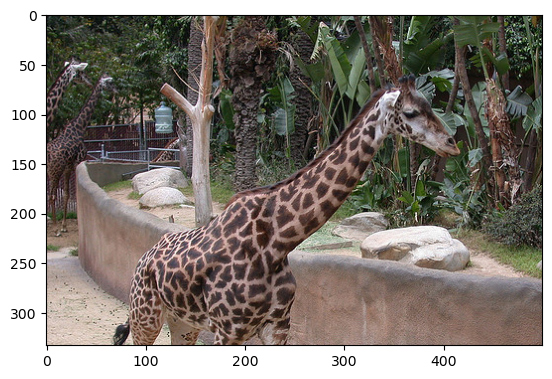

In [34]:
image, mask = resize_add_top_right(image,mask, (333, 500, 3))
plt.imshow(image)

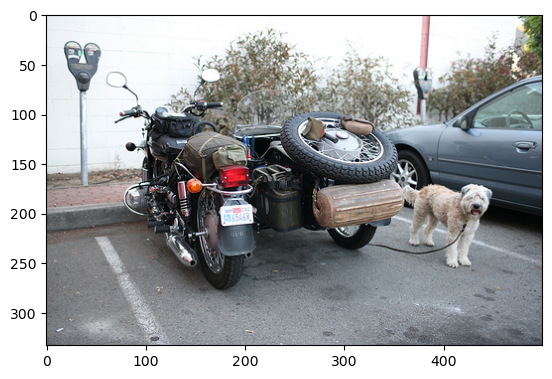

In [ ]:
bg_id = random.choice(img_ids)
bg_info = coco.loadImgs(bg_id)[0]
bg_path = os.path.join(DIR_TRAIN_IMGS, bg_info['file_name'])
background = cv2.imread(bg_path)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
h_back, w_back, _  = background.shape

min_h = min(h_orig, h_back)
min_w = min(h_orig, w_back)
plt.imshow(background)

In [27]:
background.shape

(333, 500, 3)

In [ ]:
mask = mask[,,]


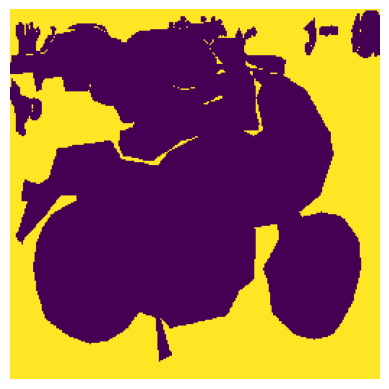

In [ ]:
plt.imshow(batch[1][0,:,:,-1])#, cmap="gray", vmin=0, vmax=1)
plt.axis("off")
plt.show()

In [22]:
background.shape

(640, 427, 3)

In [17]:
# Crop the object using the bounding box
x, y, w, h = map(int, ann['bbox'])
object_crop = image[y:y+h, x:x+w]
mask_crop = mask[y:y+h, x:x+w]

# Apply mask to crop
masked_object = cv2.bitwise_and(object_crop, object_crop, mask=mask_crop)


In [18]:
# Load background image (must be same size or bigger than crop)
bg_id = random.choice(img_ids)
bg_info = coco.loadImgs(bg_id)[0]
bg_path = os.path.join(DIR_TRAIN_IMGS, bg_info['file_name'])
background = cv2.imread(bg_path)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Resize background if needed
bg_h, bg_w = background.shape[:2]
if bg_h < h or bg_w < w:
    background = cv2.resize(background, (max(w+50, bg_w), max(h+50, bg_h)))

# Random position for blending (with overlap)
y_offset = random.randint(0, bg_h - h)
x_offset = random.randint(0, bg_w - w)

# Prepare alpha mask
alpha = mask_crop.astype(float) / 255.0
alpha = cv2.merge([alpha, alpha, alpha])

# Region of interest in background
roi = background[y_offset:y_offset+h, x_offset:x_offset+w]

# Blend
blended = (alpha * masked_object + (1 - alpha) * roi).astype(np.uint8)
background[y_offset:y_offset+h, x_offset:x_offset+w] = blended


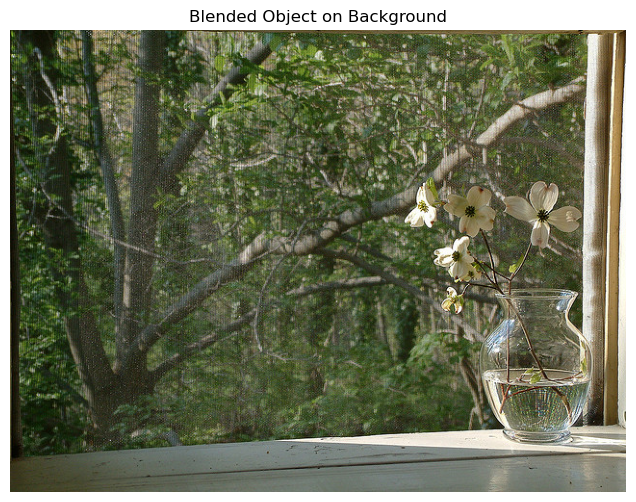

In [19]:
plt.figure(figsize=(10, 6))
plt.imshow(background)
plt.title("Blended Object on Background")
plt.axis('off')
plt.show()


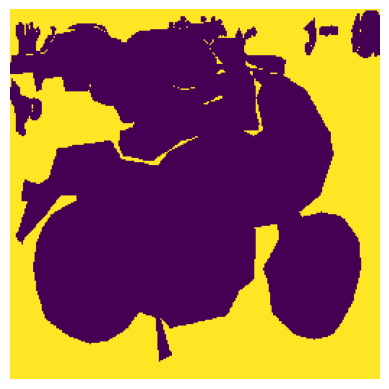

In [ ]:
plt.imshow(batch[1][0,:,:,-1])#, cmap="gray", vmin=0, vmax=1)
plt.axis("off")
plt.show()

In [ ]:


def perform_random_cropping(image, mask, items, coco)

In [ ]:

def augment_data(image, mask):

    if tf.random.uniform(()) > 0.85:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.95:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
        mask = tf.image.rot90(mask, k)

    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_brightness(image, delta=tf.random.uniform([], -0.1, 0.1))

    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_contrast(image, contrast_factor=tf.random.uniform([], 0.9, 1.1))

    if tf.random.uniform(()) > 0.85:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # # Random zoom (cropping and resizing)
    # if tf.random.uniform(()) > 0.95:
    #     scale = tf.random.uniform([], 0.8, 1.2)
    #     original_size = tf.shape(image)[:2]
    #     new_size = tf.cast(tf.cast(original_size, tf.float32) * scale, tf.int32)
    #     image = tf.image.resize(image, new_size)
    #     mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #     image = tf.image.resize_with_crop_or_pad(image, tf.shape(image)[0], tf.shape(image)[1])
    #     mask = tf.image.resize_with_crop_or_pad(mask, tf.shape(mask)[0], tf.shape(mask)[1])

    return image, mask



In [ ]:

def augment_data_advanced(image, mask):

    if tf.random.uniform(()) > 0.85:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.95:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
        mask = tf.image.rot90(mask, k)

    if tf.random.uniform(()) > 0.85:
        image = tf.image.adjust_brightness(image, delta=tf.random.uniform([], -0.1, 0.1))


    if tf.random.uniform(()) > 0.85:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)


    # # Random zoom (cropping and resizing)
    # if tf.random.uniform(()) > 0.95:
    #     scale = tf.random.uniform([], 0.8, 1.2)
    #     original_size = tf.shape(image)[:2]
    #     new_size = tf.cast(tf.cast(original_size, tf.float32) * scale, tf.int32)
    #     image = tf.image.resize(image, new_size)
    #     mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #     image = tf.image.resize_with_crop_or_pad(image, tf.shape(image)[0], tf.shape(image)[1])
    #     mask = tf.image.resize_with_crop_or_pad(mask, tf.shape(mask)[0], tf.shape(mask)[1])

    return image, mask



In [ ]:
def load_dataset(tfrecord_path, batch_size=16):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(augment_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [ ]:
def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
    return 1 - tf.reduce_mean(intersection / (union + 1e-6)) # Evita división por 0


In [ ]:
def unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)



    # Fase de downsampling: extracción de características
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck del modelo
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Fase de upsampling
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    # Salida del modelo
    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    # Se instancia como keras.Model para su uso
    model = models.Model(inputs=inputs, outputs=output)

    return model


In [ ]:

def unet_light(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Fase de downsampling: extracción de características
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck del modelo
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Fase de upsampling
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    # Salida del modelo
    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    
    # Se instancia como keras.Model para su uso

    model = models.Model(inputs=inputs, outputs=output)
    return model


In [ ]:

def unet_shallow(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Upsampling
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    output = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = models.Model(inputs=inputs, outputs=output)
    return model


In [ ]:

# Tamaño del input al que hemos adaptado el dataset
input_shape = (256, 256, 3)

model = unet_shallow(input_shape=input_shape, num_classes=N_CLASSES)



In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,   
    decay_rate=0.96,    
    # Caida del LR en intervalos discretos  
    staircase=True       )  

optimizer = Adam(learning_rate=lr_schedule)


In [ ]:

# Priemra prueba para el entrenamiento más rapido posible
model.compile(optimizer=optimizer,loss = 'mae', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss=iou_loss, metrics=[tf.keras.metrics.AUC(), 'accuracy'])


# Callbacks para ir almacenando resultados, modificar el LR de forma dinámica parad hacer que el entrenamiento converja y frenar el entrenamiento del modelo cuando no se produzca aprendizaje
callbacks = [
    ModelCheckpoint(r"/content/drive/MyDrive/TFM/first_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=10, monitor='val_loss', mode='min', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    CSVLogger(r"/content/drive/MyDrive/TFM/training_log.csv")
]



In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 93,095,821 (355.13 MB)

 Trainable params: 31,031,940 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,063,881 (236.75 MB)

Carga del `tfrecord` en memoria tanto del train como del test

In [ ]:
train_dataset = load_dataset(tfrecord_path_train, batch_size=8)
test_dataset = load_dataset(tfrecord_path_test, batch_size=8)


In [ ]:
history = model.fit(
    train_dataset.repeat(),
    steps_per_epoch=1000,
    validation_data=test_dataset,
    epochs=50,
    callbacks= callbacks,
    verbose=1
)


Epoch 1/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8264 - loss: 11.1308

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 2835s 471ms/step - accuracy: 0.8264 - loss: 11.1308 - val_accuracy: 0.8266 - val_loss: 11.1219 - learning_rate: 0.0010
Epoch 2/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 2807s 468ms/step - accuracy: 0.8271 - loss: 11.0869 - val_accuracy: 0.8266 - val_loss: 11.1219 - learning_rate: 9.6000e-04
Epoch 3/50
  11/6000 ━━━━━━━━━━━━━━━━━━━━ 42:45 428ms/step - accuracy: 0.8215 - loss: 11.4288

In [ ]:
model = keras.models.load_model(r"/content/drive/MyDrive/TFM/first_model.keras")

Mediante las funciones de `utils` se imprimen comparativas de los resultados frente al ground truth

### 2. Generación de imágenes derivadas de las actuales

Para aumentar el tamaño del conjunto de entrenamiento y poder obtener un dataset que facilite al modelo la capacidad de generalización, es necesario aplicar una fase de **data augmentation**. En este caso, se ha decidido que las transformaciones a aplicar serán las siguientes:

1. Movimientos de rotacióm
2. Movimientos de translación
3. Movimientos de zoom (implicando recorte de parte de la imagen y máscara correspondientes)
4. Cambios de brillo
5. Aplicación de ruido gausiano


Para ello, hacemos uso de una función que

In [ ]:

def augment_data(image, mask):

    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform([]) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    num_rotations = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=num_rotations)
    mask = tf.image.rot90(mask, k=num_rotations)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)


    return image, mask


In [ ]:
loss, acc = model.evaluate(dataset)
print(f"Test Accuracy: {acc:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for image, mask in dataset.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)

    image = image.numpy()
    mask = tf.argmax(mask, axis=-1).numpy()

    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(image[i])
        plt.title("Original Image")

        plt.subplot(3, 3, i*3+2)
        plt.imshow(mask[i], cmap="jet")
        plt.title("Ground Truth Mask")

        plt.subplot(3, 3, i*3+3)
        plt.imshow(pred_mask[i], cmap="jet")
        plt.title("Predicted Mask")

    plt.show()


### 2. Generación de nuevas imágenes

Para la generación de nuevas imágenes, se aplica la combinación de las siguientes técnicas:
- Rotación
- Escalado
- Traslación
- Volteo horizontal
- Cambios de brillo, contraste, saturación y gamma
- Adición de ruido gaussiano
- Aumentación Basada en Contexto Semántico